In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


## Literature

[Developing a Forecasting Model for the Power Production of Wind Turbines](https://essay.utwente.nl/74895/1/Hesselink_MA_BMS.pdf)

## Data Prep

In [95]:
pd.set_option('display.max_rows', 12)
# pd.set_option('display.max_rows', None)


In [119]:
power_curve = pd.read_csv("suppy_forecasting_data/power_curve.csv")
power_curve = power_curve.drop(["Manufacturername", "Turbine_ID", "Turbine_name"], axis=1)

c = power_curve.columns
power_curve = power_curve.transpose()
power_curve['windspeed(m/s)'] = c.map(lambda x: float(x.replace("kWat", "").replace("m/s", "")))
power_curve = power_curve.rename(columns = {0:'Power Output(kWat)'})
power_curve = power_curve.reset_index(drop=True)

power_curve.head()

,Power Output(kWat),windspeed(m/s)
0,0,0.0
1,0,0.5
2,0,1.0
3,0,1.5
4,0,2.0


In [550]:
allocation = pd.read_csv("suppy_forecasting_data/allocation.csv", 
        usecols=["datetime_from(AMStz)", "production(kWh)"]
    )

allocation['datetime_from(UTC)'] = pd.to_datetime(allocation['datetime_from(AMStz)'], utc=True)
allocation = allocation.set_index("datetime_from(UTC)")
allocation = allocation.drop("datetime_from(AMStz)", axis=1)
allocation.head()

,production(kWh)
datetime_from(UTC),
2017-12-31 23:00:00+00:00,4405.0
2017-12-31 23:15:00+00:00,4430.0
2017-12-31 23:30:00+00:00,4432.0
2017-12-31 23:45:00+00:00,4424.0
2018-01-01 00:00:00+00:00,4400.0


In [555]:
weather_actuals_original = pd.read_csv("suppy_forecasting_data/weather_actuals.csv", index_col=['datetime_from(UTC)'], parse_dates=["datetime_from(UTC)"])
weather_actuals_original = weather_actuals_original.resample("15T").interpolate()

weather_actuals = pd.read_csv("suppy_forecasting_data/weather_actuals.csv", index_col=['datetime_from(UTC)'],
parse_dates=["datetime_from(UTC)"],
usecols=[
    "datetime_from(UTC)",
    # "datetime_until(UTC)",
    "wind_direction(deg)",
    "wind_speed(m/s)",
    "temperature(C)"
    ], squeeze=True)

weather_actuals = weather_actuals.resample("15T").interpolate()

weather_actuals['date'] = weather_actuals.index.to_period('M')
weather_actuals = weather_actuals.merge(allocation, left_on="datetime_from(UTC)", right_on="datetime_from(UTC)")
weather_actuals_original = weather_actuals_original.merge(allocation, left_on="datetime_from(UTC)", right_on="datetime_from(UTC)")
weather_actuals.head()

/Users/katringrunert/Projects/data_science/test/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


,wind_direction(deg),wind_speed(m/s),temperature(C),date,production(kWh)
datetime_from(UTC),,,,,
2017-12-31 23:00:00+00:00,220.0,10.0,8.300,2017-12,4405.0
2017-12-31 23:15:00+00:00,220.0,10.5,8.325,2017-12,4430.0
2017-12-31 23:30:00+00:00,220.0,11.0,8.350,2017-12,4432.0
2017-12-31 23:45:00+00:00,220.0,11.5,8.375,2017-12,4424.0
2018-01-01 00:00:00+00:00,220.0,12.0,8.400,2018-01,4400.0


In [552]:
weather_forecasts = pd.read_csv("suppy_forecasting_data/weather_forecasts.csv", index_col=['datetime_from(UTC)'],
                    parse_dates=["datetime_from(UTC)"],
                    usecols=[
                        "datetime_from(UTC)",
                        # "datetime_until(UTC)",
                        "wind_direction(deg)",
                        "wind_speed(m/s)",
                        "temperature(K)"
                        ], squeeze=True)
weather_forecasts = weather_forecasts.resample("15T").interpolate()
weather_forecasts['date'] = weather_forecasts.index.to_period('M')
weather_forecasts = weather_forecasts.merge(allocation, left_on="datetime_from(UTC)", right_on="datetime_from(UTC)")
weather_forecasts.head()

/Users/katringrunert/Projects/data_science/test/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


,wind_direction(deg),temperature(K),wind_speed(m/s),date,production(kWh)
datetime_from(UTC),,,,,
2017-12-31 23:00:00+00:00,217.755322,279.998291,11.370529,2017-12,4405.0
2017-12-31 23:15:00+00:00,216.216868,279.945740,11.017697,2017-12,4430.0
2017-12-31 23:30:00+00:00,214.678413,279.893188,10.664866,2017-12,4432.0
2017-12-31 23:45:00+00:00,213.139959,279.840637,10.312034,2017-12,4424.0
2018-01-01 00:00:00+00:00,211.601505,279.788086,9.959202,2018-01,4400.0


### Outlier Detection

In [417]:
def scatter_plot(x, y, data, ax, y_lim):
    ax.set(ylim=y_lim)
    sns.scatterplot(y=y, x=x, data=data, ax=ax)

In [486]:
from sklearn.ensemble import IsolationForest 

print(weather_actuals.shape)

iso = IsolationForest(random_state=12)
y_outliers = iso.fit_predict(weather_actuals.drop(['date', 'production(kWh)'], axis=1))

weather_actuals_copy = weather_actuals.iloc[(y_outliers != -1), :]

print(weather_actuals_copy.shape)
weather_actuals_copy.head()

(105213, 5)
(87526, 5)


,wind_direction(deg),wind_speed(m/s),temperature(C),date,production(kWh)
datetime_from(UTC),,,,,
2017-12-31 23:00:00+00:00,220.0,10.0,8.300,2017-12,4405.0
2017-12-31 23:15:00+00:00,220.0,10.5,8.325,2017-12,4430.0
2017-12-31 23:30:00+00:00,220.0,11.0,8.350,2017-12,4432.0
2018-01-01 04:00:00+00:00,250.0,10.0,7.500,2018-01,4437.0
2018-01-01 04:15:00+00:00,250.0,10.0,7.350,2018-01,4380.0


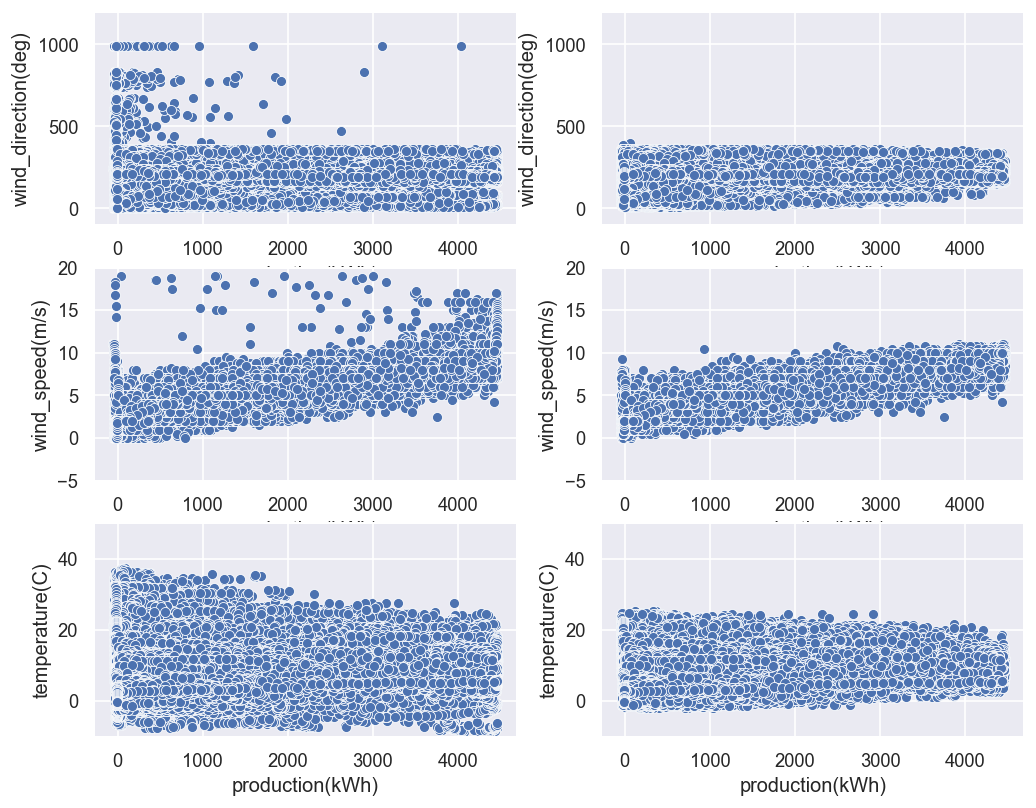

In [557]:

sns.set(rc={"figure.figsize":(10, 8)})

fig, axes = plt.subplots(3, 2)

scatter_plot(y="wind_direction(deg)", x="production(kWh)", data=weather_actuals, ax=axes[0,0], y_lim=(-100, 1200))
scatter_plot(y="wind_direction(deg)", x="production(kWh)", data=weather_actuals_copy, ax=axes[0,1], y_lim=(-100, 1200))
scatter_plot(y="wind_speed(m/s)",     x="production(kWh)", data=weather_actuals, ax=axes[1,0], y_lim=(-5, 20))
scatter_plot(y="wind_speed(m/s)",     x="production(kWh)", data=weather_actuals_copy, ax=axes[1,1], y_lim=(-5, 20))
scatter_plot(y="temperature(C)",      x="production(kWh)", data=weather_actuals, ax=axes[2,0], y_lim=(-10, 50))
scatter_plot(y="temperature(C)",      x="production(kWh)", data=weather_actuals_copy, ax=axes[2,1], y_lim=(-10, 50))
# plt.savefig("outlier_removal.png")
plt.show()


## Training Test Split

In [488]:
df = weather_actuals_copy.copy()

In [515]:
y = df["production(kWh)"]#.reset_index(drop=True)
X = df[["wind_direction(deg)", "wind_speed(m/s)", "temperature(C)"]]

X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=False)

In [507]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_copy = X.copy()

X_scaled = pd.DataFrame(scaler.fit_transform(X_copy), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, shuffle=False)

## ARIMA Model Preparation (not important/used)

In [558]:
from sklearn.model_selection import train_test_split

weather_actuals['date'] = weather_actuals.index.to_period('M')
weather_actuals['year'] = weather_actuals.index.year
productionDf = weather_actuals["production(kWh)"].dropna()

s = productionDf.size
train = productionDf[int(s*0.15):]
test = productionDf[:int(s*0.15)]

/Users/katringrunert/Projects/data_science/test/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1146: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [243]:
from statsmodels.tsa.stattools import adfuller

df = weather_actuals["production(kWh)"]#.resample("1D").mean()

In [265]:
df[df.index == "2018"]

datetime_from(UTC)
2018-01-01 00:00:00+00:00    4400.0
Name: production(kWh), dtype: float64

In [251]:
def get_stationarity(timeseries, window=48):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=window).mean()
    rolling_std = timeseries.rolling(window=window).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

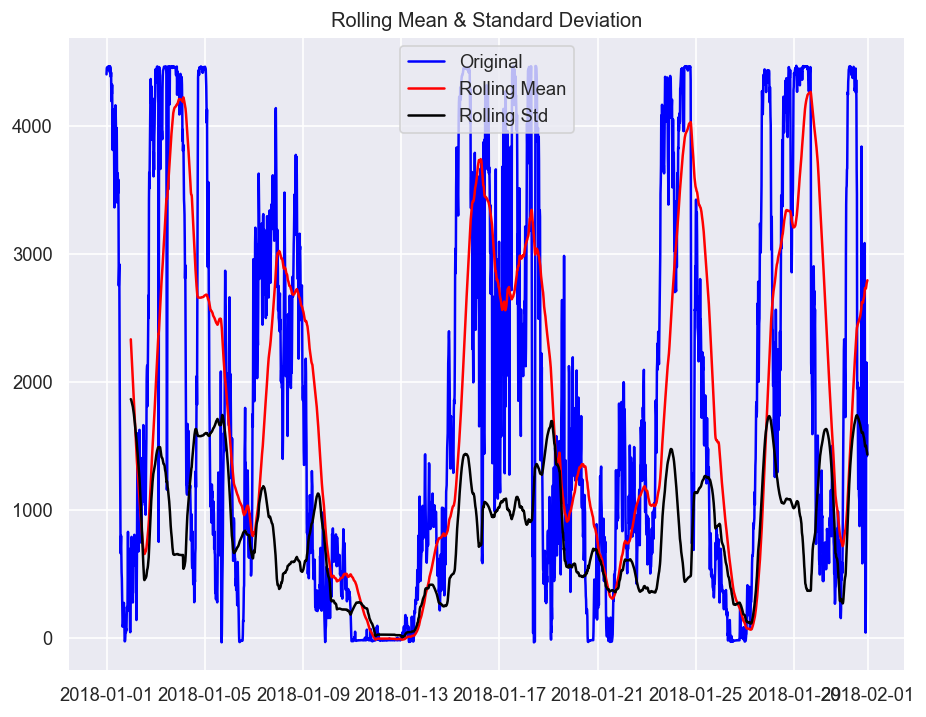

ADF Statistic: -4.865612341350354
p-value: 4.066730230660271e-05
Critical Values:
	1%: -3.4325596475930493
	5%: -2.8625162775163204
	10%: -2.567289698968843


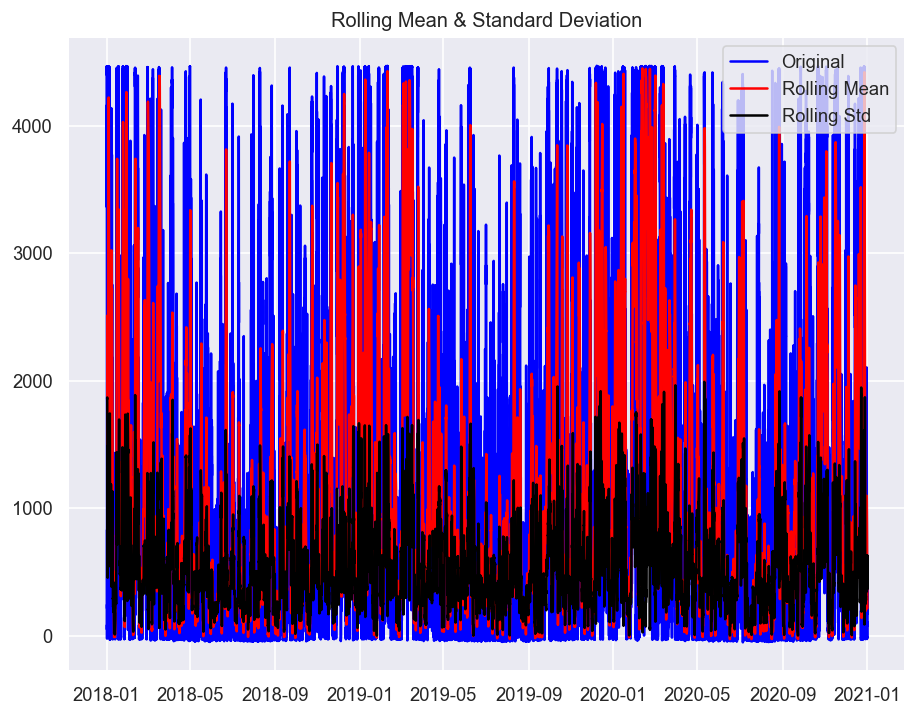

ADF Statistic: -18.86939218419903
p-value: 0.0
Critical Values:
	1%: -3.4304121958633136
	5%: -2.861567489611982
	10%: -2.5667846317559513


In [271]:

get_stationarity(df[(df.index >= "2018-01") & (df.index < "2018-02")], 96)
get_stationarity(df, 96)

/Users/katringrunert/Projects/data_science/test/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/katringrunert/Projects/data_science/test/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


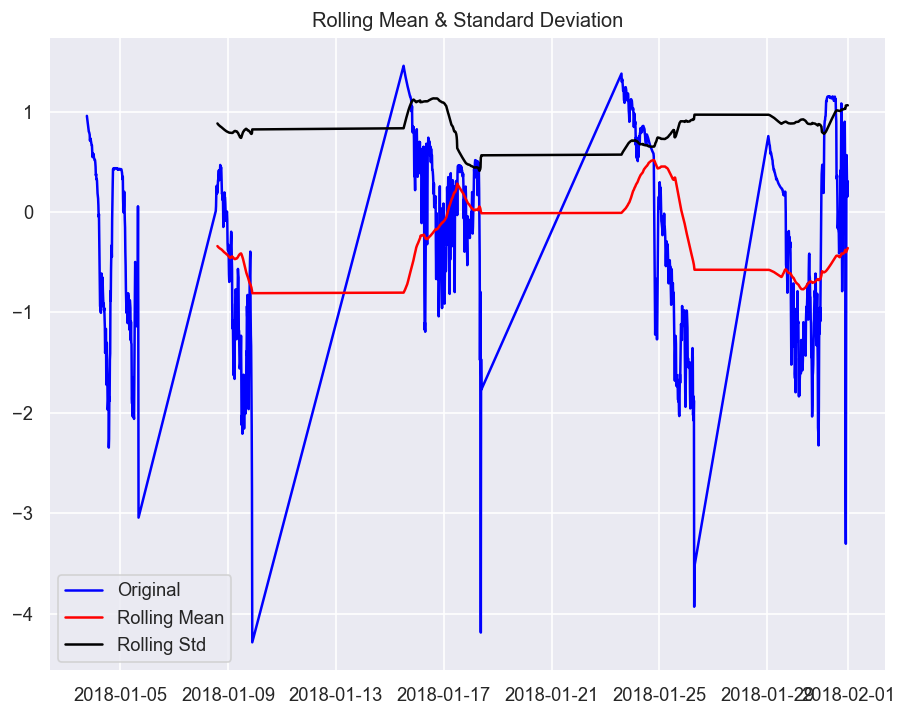

ADF Statistic: -4.9192503388859325
p-value: 3.1987070970799215e-05
Critical Values:
	1%: -3.4361296862775528
	5%: -2.8640920853813365
	10%: -2.5681287981237304


In [279]:
df_log = np.log(df[(df.index >= "2018-01") & (df.index < "2018-02")])
rolling_mean = df_log.rolling(window=192).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)

get_stationarity(df_log_minus_mean, 192)

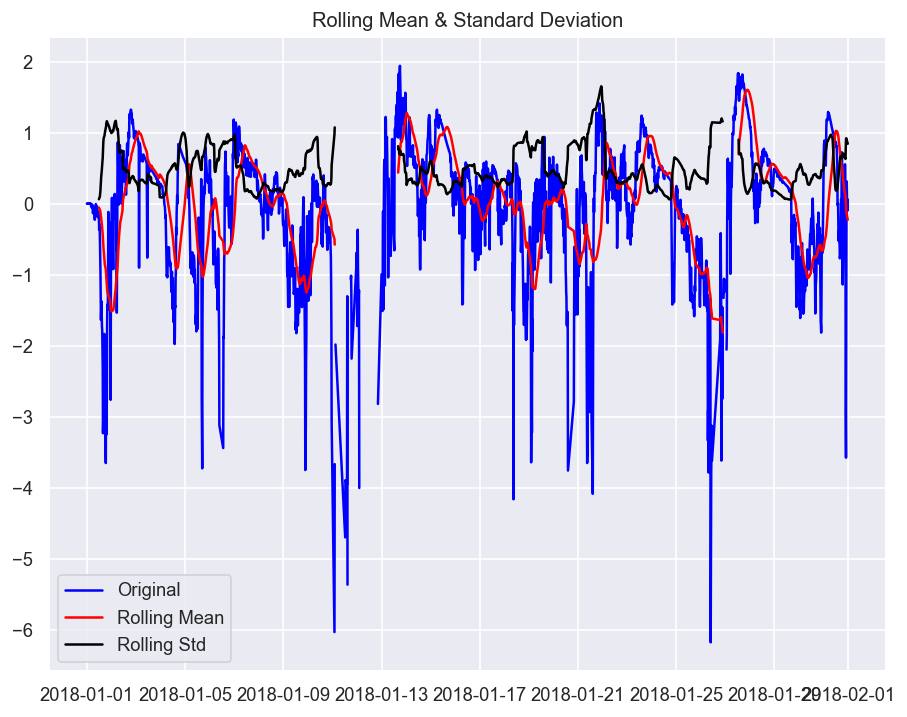

MissingDataError: exog contains inf or nans

In [276]:
rolling_mean_exp_decay = df_log.ewm(halflife=48, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay, 48)

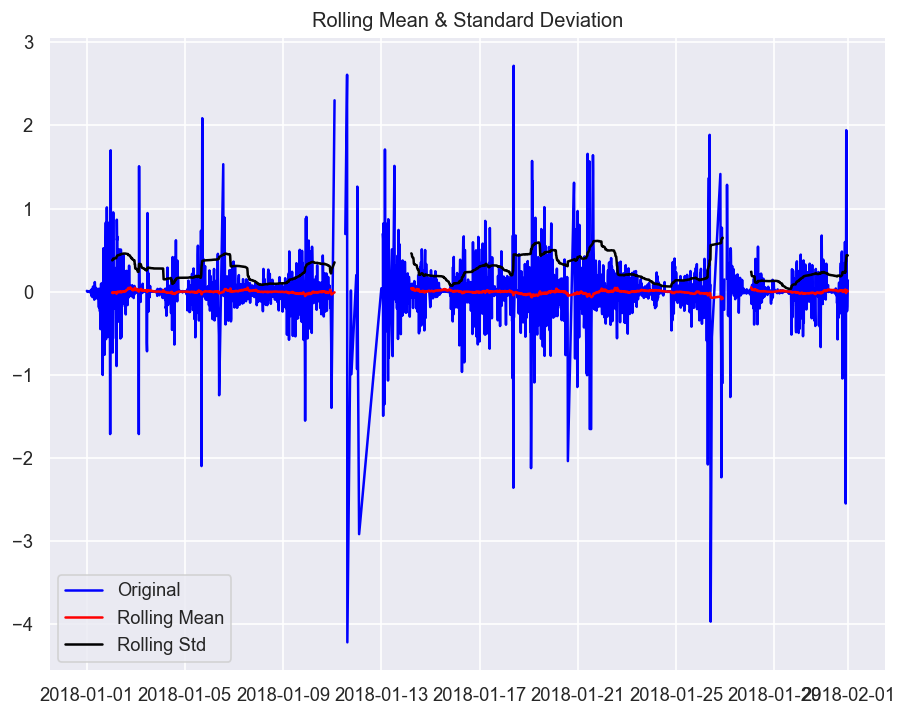

MissingDataError: exog contains inf or nans

In [277]:
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift, 96)

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(train.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(train.diff().dropna(), ax=axes[1])

plt.show()

## Storing and Loading of models

In [530]:
import pickle

pickle.dump(rf, open('models/model_randomforest.pkl', 'wb'))
pickle.dump(poly4, open('models/model_polynom_4.pkl', 'wb'))
pickle.dump(poly5, open('models/model_polynom_5.pkl', 'wb'))

### load them

In [532]:
rf = pickle.load(open('models/model_randomforest.pkl', 'rb'))
poly5 = pickle.load(open('models/model_polynom_5.pkl', 'rb'))
poly4 = pickle.load(open('models/model_polynom_4.pkl', 'rb'))

### or train them

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=12)
rf.fit(X_train, y_train)

poly4 = make_pipeline(PolynomialFeatures(degree = 4), LinearRegression())
poly4.fit(X_train, y_train)

poly5 = make_pipeline(PolynomialFeatures(degree = 5), LinearRegression())
poly5.fit(X_train, y_train)


## Random Forest Regression

### Random Forest Regression with multivariate data

In [533]:
rf_y_predict = rf.predict(X_test)

<AxesSubplot:xlabel='datetime_from(UTC)', ylabel='production(kWh)'>

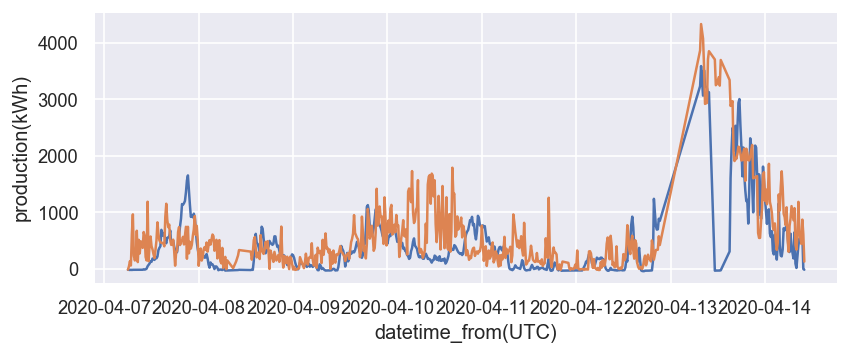

In [534]:
sns.set(rc={"figure.figsize":(8, 3)})

until = 600

sns.lineplot(x=X_test.index[:until], y=y_test[:until])
sns.lineplot(x=X_test.index[:until], y=rf_y_predict[:until])

## Polynomial Regression

In [522]:
pr_y_predict1 = poly4.predict(X_test)
pr_y_predict2 = poly5.predict(X_test)

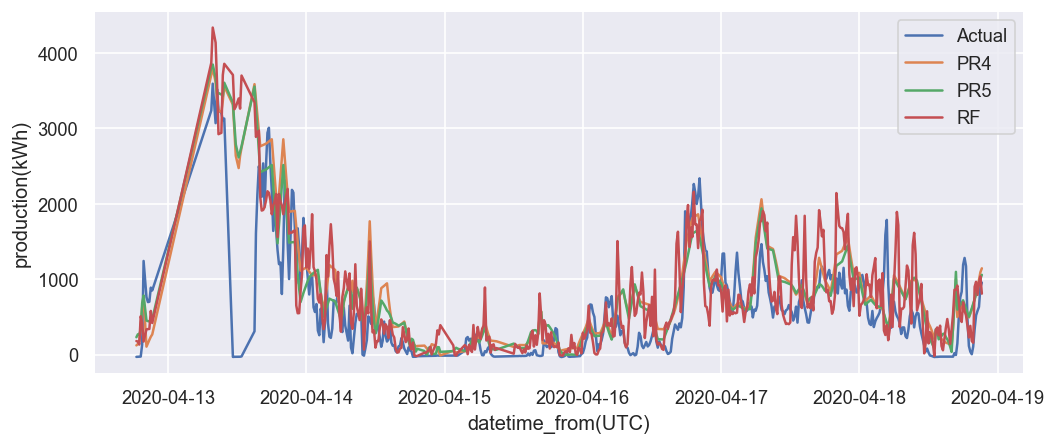

In [529]:
sns.set(rc={"figure.figsize":(10, 4)})

fr = 500
until = 1000

sns.lineplot(x=X_test.index[fr:until], y=y_test[fr:until])
sns.lineplot(x=X_test.index[fr:until], y=pr_y_predict1[fr:until])
sns.lineplot(x=X_test.index[fr:until], y=pr_y_predict2[fr:until])
# sns.lineplot(x=X_test.index[fr:until], y=rf_y_predict[fr:until])

plt.legend(labels=["Actual", "PR4", "PR5", "RF"])
# plt.legend(labels=["Actual", "RF"])

# plt.savefig("comparison_all.png")
plt.show()


## Error Comparison

In [513]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Random Forest Regression
rf_errors = {
    "MSE": mean_squared_error(y_test, rf_y_predict),
    "RMSE": np.sqrt(mean_squared_error(y_test, rf_y_predict)),
    "MAE": mean_absolute_error(y_test, rf_y_predict),
}

#Polynomial Regression 4th Grade
pr4_errors = {
    "MSE": mean_squared_error(y_test, pr_y_predict1),
    "RMSE": np.sqrt(mean_squared_error(y_test, pr_y_predict1)),
    "MAE": mean_absolute_error(y_test, pr_y_predict1),
}

pr5_errors = {
    "MSE": mean_squared_error(y_test, pr_y_predict2),
    "RMSE": np.sqrt(mean_squared_error(y_test, pr_y_predict2)),
    "MAE": mean_absolute_error(y_test, pr_y_predict2),
}


def print_errors(model, errors):
    print(model)
    for k in errors:
        print(k, ": ", np.round(errors[k], 3))
    print()

In [514]:
print_errors("Random Forest Regression", rf_errors)
print_errors("Polynomial Regression (4th)", pr4_errors)
print_errors("Polynomial Regression (5th)", pr5_errors)


Random Forest Regression
MSE :  283374.413
RMSE :  532.329
MAE :  373.071

Polynomial Regression (4th)
MSE :  214898.708
RMSE :  463.572
MAE :  329.683

Polynomial Regression (5th)
MSE :  212512.963
RMSE :  460.991
MAE :  329.388



## Data Visualization

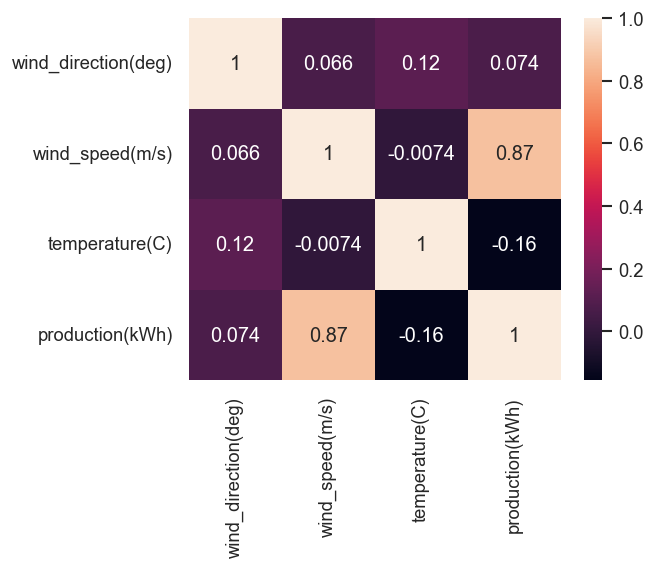

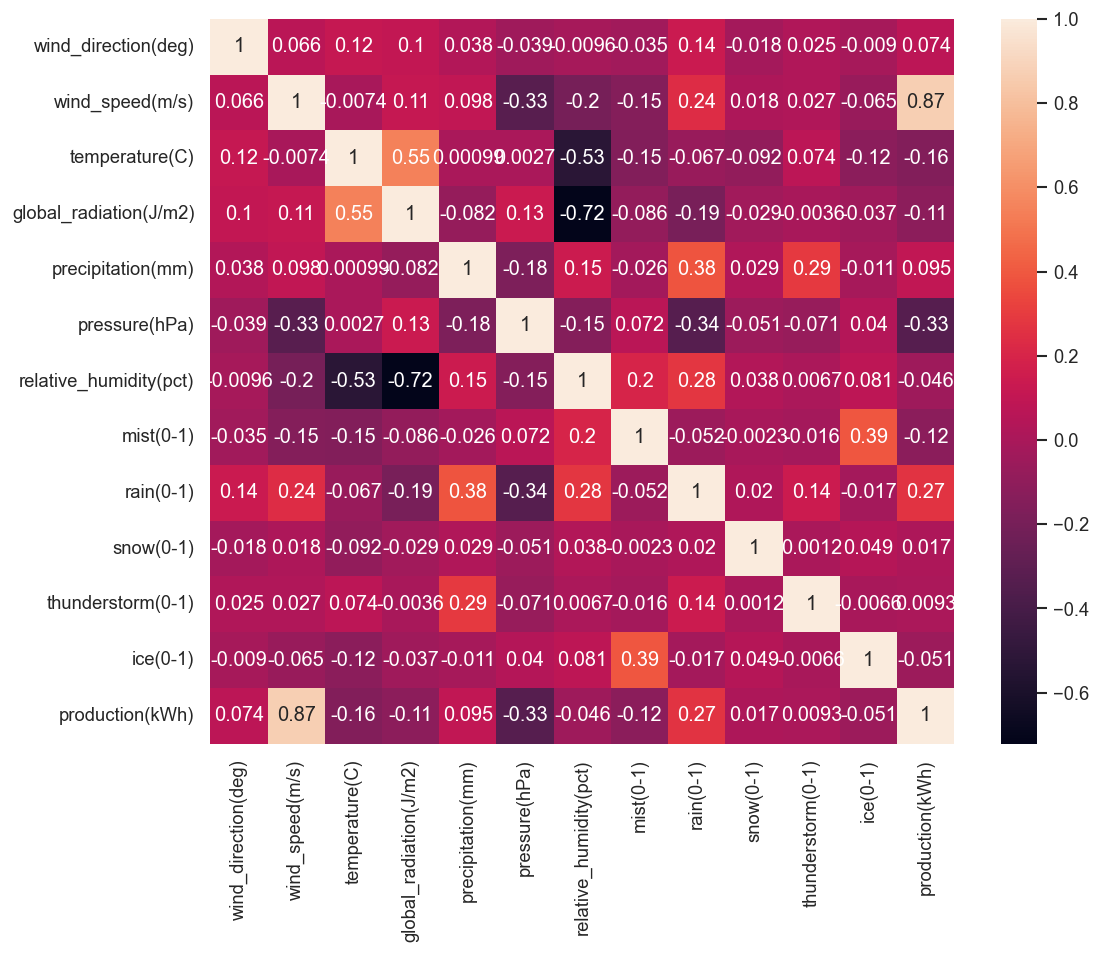

In [556]:

sns.set(rc={"figure.figsize":(5,4)})
sns.heatmap(weather_actuals.corr(), annot=True)
plt.show()
sns.set(rc={"figure.figsize":(10,8)})
sns.heatmap(weather_actuals_original.corr(), annot=True)
plt.show()


### Power Curve Plot

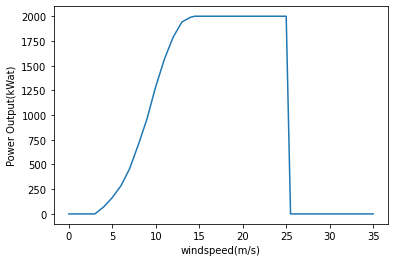

In [121]:
sns.lineplot(x="windspeed(m/s)", y="Power Output(kWat)",
            #  hue="region", style="event",
             data=power_curve)
plt.show()

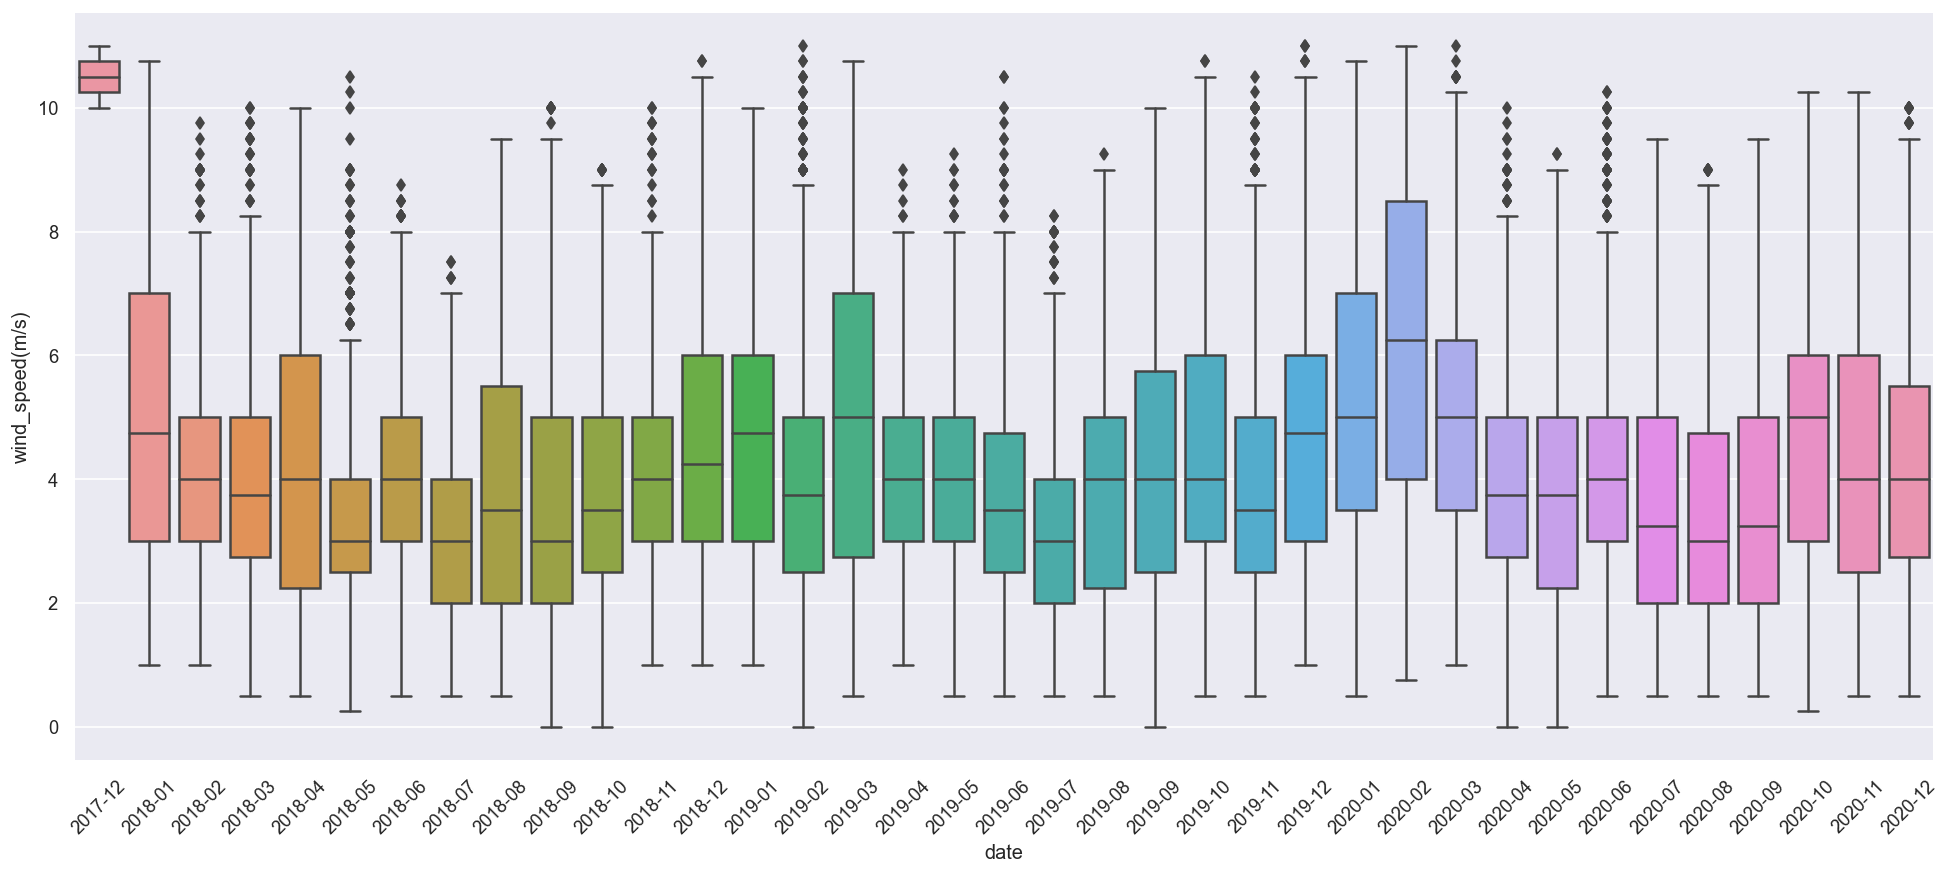

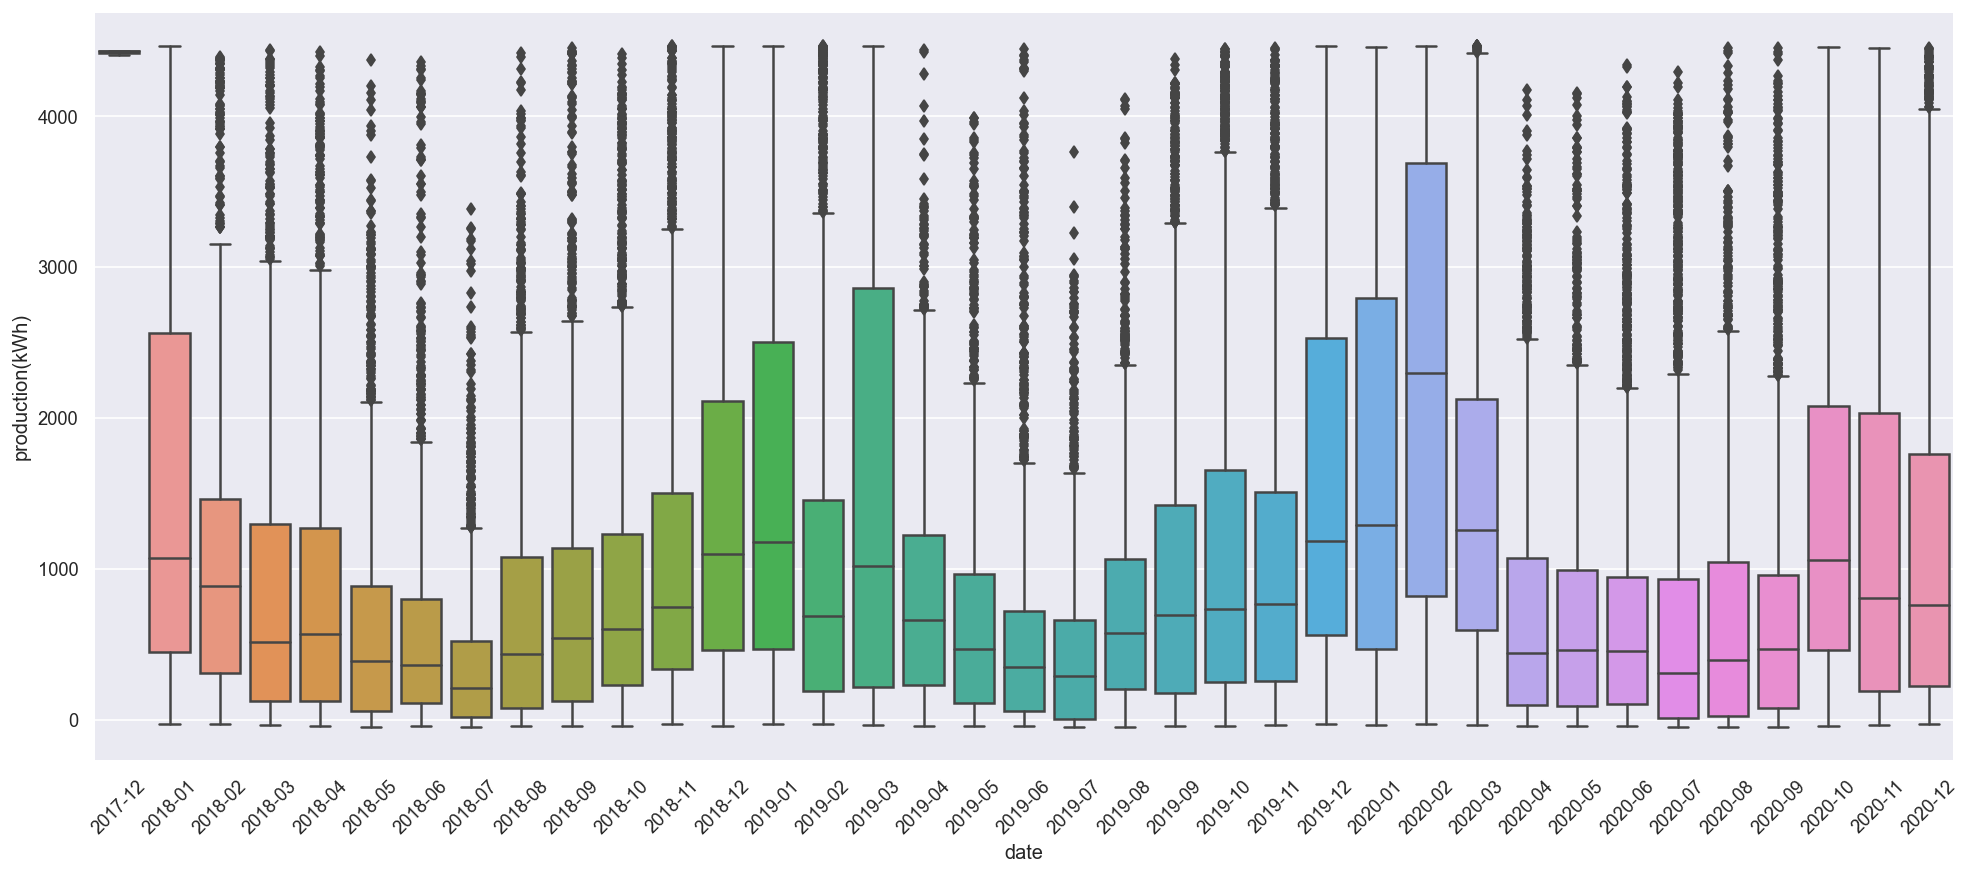

In [559]:
# weather_actuals.head()
df = weather_actuals_copy.copy()
# df = weather_actuals.copy()

sns.set(rc={'figure.figsize':(20,8.27)})
ax = sns.boxplot(x="date", y="wind_speed(m/s)", data=df)
plt.xticks(rotation=45)
plt.show()
ax = sns.boxplot(x="date", y="production(kWh)", data=df)
plt.xticks(rotation=45)
plt.show()

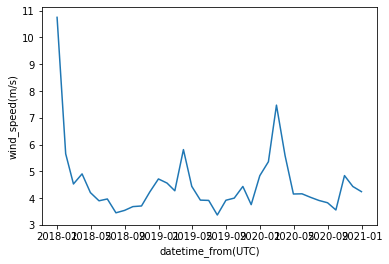

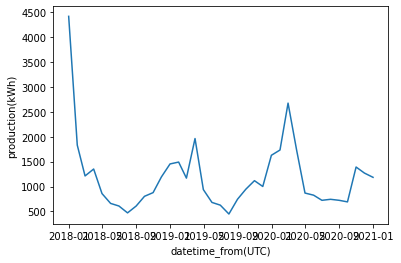

In [129]:
sns.lineplot(x="datetime_from(UTC)", y="wind_speed(m/s)",
            #  hue="region", style="event",
             data=weather_actuals.resample("M").mean())
plt.show()

sns.lineplot(x="datetime_from(UTC)", y="production(kWh)",
            #  hue="region", style="event",
             data=weather_actuals.resample("M").mean())
plt.show()

In [233]:
power_curve = pd.read_csv("suppy_forecasting_data/power_curve.csv")
pd.set_option('max_rows', None)

power_curve.T

,0
Manufacturername,Vestas
Turbine_ID,30
Turbine_name,V80/2000
kWat0.0m/s,0
kWat0.5m/s,0
kWat1.0m/s,0
kWat1.5m/s,0
kWat2.0m/s,0
kWat2.5m/s,0
kWat3.0m/s,0


In [234]:
pd.reset_option('max_columns')
pd.reset_option('max_rows')